In [75]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.7.1


- transductive learning -> given the ground truth labels of only a small subset of nodes and want to infer labels for all the remaining nodes
- will use the Cora dataset (citation network)
- each node in the dataset is descirbed by a 1422-dim bag of words feature vector
- task: infer the category of each document (7 total)

In [76]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


- for training, we are given the ground-truth categories of 140 nodes (20 each class) -> training node label rate is 5%
- graph also holds val_mask and test_mask attributes, which is what we will use for validation and testing
- will use data transformation via transform=NormalizeFeatures() -> can be used to modify input data before inputting them into NN (e.g. normalization or data augmentation) -> will use for row normalizing


In [77]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


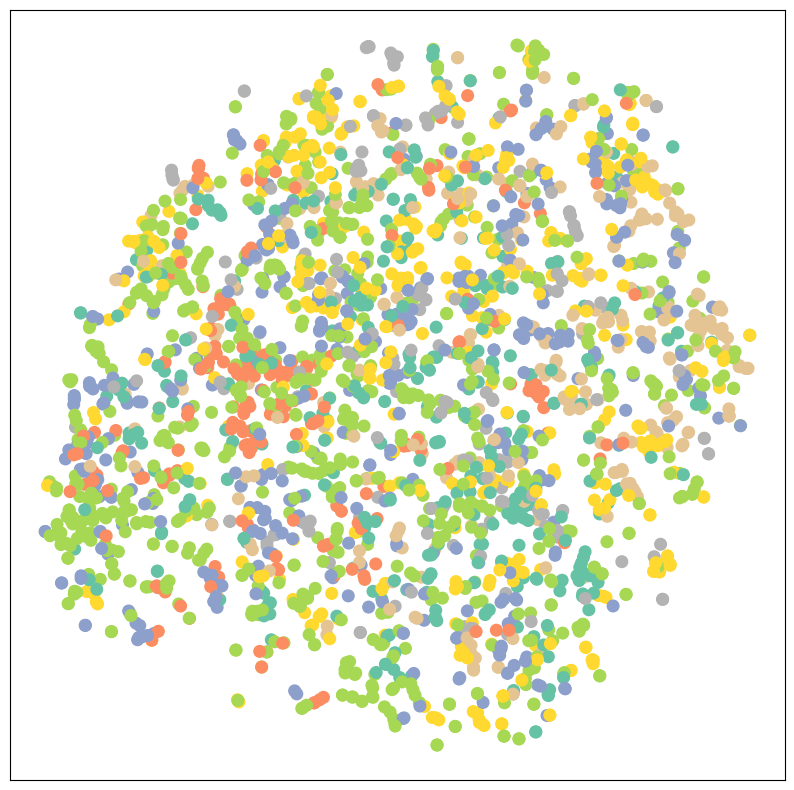

In [78]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [79]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) #use class with highest probability
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 200):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


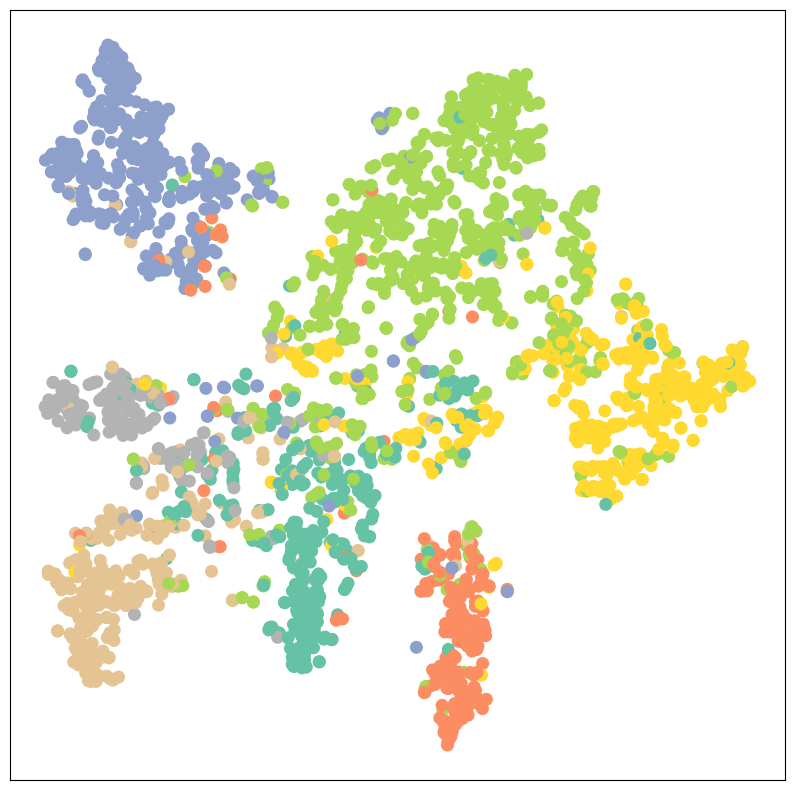

In [80]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)